In [ ]:
from Capsule.Layer.CapsuleLayer import CapsuleRouting
import torch
routing = CapsuleRouting(mode='em')

v = torch.rand(2, 8, 10, 16, 1, 1)
a = torch.rand(2, 8, 1, 1)
v, a = routing(v, a)
print(a)

In [ ]:
from Capsule.Layer.CapsuleLayer import AdaptiveCapsuleHead
import torch

model = AdaptiveCapsuleHead(32, 10, 4, 1, False, *["dynamic", 10, 1.5])
v = torch.rand(2, 32, 5, 5)

out, v = model(v, get_capsules=True)
print(v.shape)
print(v)

In [ ]:
import yaml
import torch
from Capsule.Layer.Classifier import CapsuleWrappingClassifier
with open('config/new-config.yml', 'r') as stream:
    PARAMS = yaml.safe_load(stream)
    print(PARAMS)
model = CapsuleWrappingClassifier(model_configs=PARAMS['architect_settings'])

img = torch.rand(2, 3, 224, 224)

out = model(img)
print(out.shape)
print(out)

/home/vips/anaconda3/envs/Capsule/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0


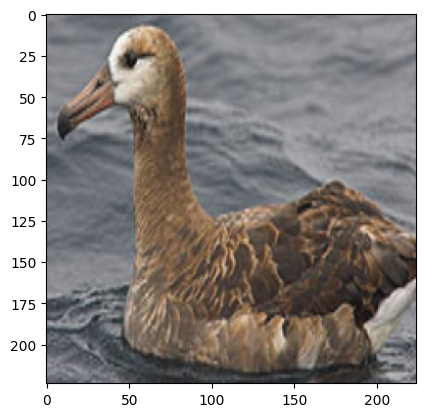

In [1]:
from Capsule.ultis import Cub2011
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage
dataset = Cub2011(mode='test', data_path='data/CUB_200_2011', transform=None)

img, label, oimg = dataset[10]
print(label)
plt.imshow(ToPILImage()(oimg))
plt.show()